In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv
/kaggle/input/equity-post-HCT-survival-predictions/data_dictionary.csv
/kaggle/input/equity-post-HCT-survival-predictions/train.csv
/kaggle/input/equity-post-HCT-survival-predictions/test.csv


In [2]:
#Loading necessary packages

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()

___

In [3]:
# Uploading datasets

df_train= pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv")
df_test = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/test.csv')
df_dict=pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/data_dictionary.csv')

In [4]:
# Exploring the train dataset

df_train.head()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,...,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


In [5]:
df_dict.info

<bound method DataFrame.info of                   variable                                        description  \
0                dri_score                         Refined disease risk index   
1            psych_disturb                            Psychiatric disturbance   
2               cyto_score                                  Cytogenetic score   
3                 diabetes                                           Diabetes   
4         hla_match_c_high  Recipient / 1st donor allele level (high resol...   
5           hla_high_res_8  Recipient / 1st donor allele-level (high resol...   
6               tbi_status                                                TBI   
7               arrhythmia                                         Arrhythmia   
8            hla_low_res_6  Recipient / 1st donor antigen-level (low resol...   
9               graft_type                                         Graft type   
10               vent_hist                  History of mechanical ventilation

## Data Pre- processing for train set 🛠️

In [6]:
# Printing unique values in each column

print("Unique values in each column:")
for column in df_train.columns:
    unique_values = df_train[column].unique()
    print(f"{column}: {unique_values}")

Unique values in each column:
ID: [    0     1     2 ... 28797 28798 28799]
dri_score: ['N/A - non-malignant indication' 'Intermediate' 'High' 'Low'
 'N/A - disease not classifiable' 'N/A - pediatric' 'TBD cytogenetics'
 'Intermediate - TED AML case <missing cytogenetics' nan
 'High - TED AML case <missing cytogenetics' 'Very high'
 'Missing disease status']
psych_disturb: ['No' 'Not done' 'Yes' nan]
cyto_score: [nan 'Intermediate' 'Poor' 'Other' 'Favorable' 'TBD' 'Normal' 'Not tested']
diabetes: ['No' 'Yes' 'Not done' nan]
hla_match_c_high: [nan  2.  1.  0.]
hla_high_res_8: [nan  8.  7.  5.  6.  4.  3.  2.]
tbi_status: ['No TBI' 'TBI +- Other, >cGy' 'TBI + Cy +- Other' 'TBI +- Other, <=cGy'
 'TBI +- Other, unknown dose' 'TBI +- Other, -cGy, fractionated'
 'TBI +- Other, -cGy, single' 'TBI +- Other, -cGy, unknown dose']
arrhythmia: ['No' 'Yes' nan 'Not done']
hla_low_res_6: [ 6.  4.  3. nan  5.  2.]
graft_type: ['Bone marrow' 'Peripheral blood']
vent_hist: ['No' 'Yes' nan]
renal_issue:

In [7]:
# collecting all numerical columns into one dataframe

numerical_df = df_train.select_dtypes(include=['int64', 'float64'])

# Substituting all missing values with 0 or 1 depending on the datatype(int,float)

numerical_df[numerical_df.select_dtypes(include='number').columns] = numerical_df.select_dtypes(include='number').apply(
    lambda col: col.fillna(-1) if col.dtype == 'float64' else col)
numerical_df[numerical_df.select_dtypes(include='number').columns] = numerical_df.select_dtypes(include='number').apply(
    lambda col: col.fillna(0) if col.dtype == 'int64' else col)


In [8]:
# Checking if null values exist

numerical_df.isnull().sum()

ID                     0
hla_match_c_high       0
hla_high_res_8         0
hla_low_res_6          0
hla_high_res_6         0
hla_high_res_10        0
hla_match_dqb1_high    0
hla_nmdp_6             0
hla_match_c_low        0
hla_match_drb1_low     0
hla_match_dqb1_low     0
year_hct               0
hla_match_a_high       0
donor_age              0
hla_match_b_low        0
age_at_hct             0
hla_match_a_low        0
hla_match_b_high       0
comorbidity_score      0
karnofsky_score        0
hla_low_res_8          0
hla_match_drb1_high    0
hla_low_res_10         0
efs                    0
efs_time               0
dtype: int64

___

#### <div class="alert alert-block alert-info"> 📌 There are 2 target values (efs_time, efs). Here, Converting 2 target variables into one. The values in 'efs_time' are conitinuous unlike 'efs' which are binary.Hence, 'efs_time' column will be scaled using MinMaxScaler. Finally, 'efs_time' and 'efs' will combined into single column.  </div>

In [9]:
from sklearn.preprocessing import MinMaxScaler
# Step 1: Scale efs_time to the range [0.1, 1.0]
scaler = MinMaxScaler(feature_range=(0.1, 1.0))

numerical_df['efs_time_scaled'] = scaler.fit_transform(numerical_df[['efs_time']])

# Step 2: Combine efs and scaled efs_time

numerical_df['target'] = numerical_df['efs'] * 0.5  + numerical_df['efs_time_scaled'] * 0.5 

#### <div class="alert alert-block alert-info"> 📌 Filling missing values in object type columns with 'Unknown'. Finally, Converting all object type columns into numerical type  </div>

In [10]:
numerical_df_object = df_train.select_dtypes(include=['object'])
numerical_df_object = numerical_df_object.fillna('Unknown')

In [11]:
numerical_df_object['dri_score'] = label_encoder.fit_transform(numerical_df_object['dri_score'])
numerical_df_object['psych_disturb'] = label_encoder.fit_transform(numerical_df_object['psych_disturb'])
numerical_df_object['cyto_score'] = label_encoder.fit_transform(numerical_df_object['cyto_score'])
numerical_df_object['diabetes'] = label_encoder.fit_transform(numerical_df_object['diabetes'])
numerical_df_object['tbi_status'] = label_encoder.fit_transform(numerical_df_object['tbi_status'])
numerical_df_object['arrhythmia'] = label_encoder.fit_transform(numerical_df_object['arrhythmia'])
numerical_df_object['graft_type'] = label_encoder.fit_transform(numerical_df_object['graft_type'])
numerical_df_object['vent_hist'] = label_encoder.fit_transform(numerical_df_object['vent_hist'])
numerical_df_object['renal_issue'] = label_encoder.fit_transform(numerical_df_object['renal_issue'])
numerical_df_object['pulm_severe'] = label_encoder.fit_transform(numerical_df_object['pulm_severe'])
numerical_df_object['gvhd_proph'] = label_encoder.fit_transform(numerical_df_object['gvhd_proph'])
numerical_df_object['sex_match'] = label_encoder.fit_transform(numerical_df_object['sex_match'])
numerical_df_object['hepatic_mild'] = label_encoder.fit_transform(numerical_df_object['hepatic_mild'])
numerical_df_object['tce_div_match'] = label_encoder.fit_transform(numerical_df_object['tce_div_match'])
numerical_df_object['hepatic_mild'] = label_encoder.fit_transform(numerical_df_object['hepatic_mild'])
numerical_df_object['donor_related'] = label_encoder.fit_transform(numerical_df_object['donor_related'])
numerical_df_object['melphalan_dose'] = label_encoder.fit_transform(numerical_df_object['melphalan_dose'])
numerical_df_object['cardiac'] = label_encoder.fit_transform(numerical_df_object['cardiac'])
numerical_df_object['pulm_moderate'] = label_encoder.fit_transform(numerical_df_object['pulm_moderate'])
numerical_df_object['rheum_issue'] = label_encoder.fit_transform(numerical_df_object['rheum_issue'])
numerical_df_object['race_group'] = label_encoder.fit_transform(numerical_df_object['race_group'])
numerical_df_object['prim_disease_hct'] = label_encoder.fit_transform(numerical_df_object['prim_disease_hct'])
numerical_df_object['cmv_status'] = label_encoder.fit_transform(numerical_df_object['cmv_status'])
numerical_df_object['tce_imm_match'] = label_encoder.fit_transform(numerical_df_object['tce_imm_match'])
numerical_df_object['rituximab'] = label_encoder.fit_transform(numerical_df_object['rituximab'])
numerical_df_object['prod_type'] = label_encoder.fit_transform(numerical_df_object['prod_type'])
numerical_df_object['cyto_score_detail'] = label_encoder.fit_transform(numerical_df_object['cyto_score_detail'])
numerical_df_object['conditioning_intensity'] = label_encoder.fit_transform(numerical_df_object['conditioning_intensity'])
numerical_df_object['ethnicity'] = label_encoder.fit_transform(numerical_df_object['ethnicity'])
numerical_df_object['obesity'] = label_encoder.fit_transform(numerical_df_object['obesity'])
numerical_df_object['mrd_hct'] = label_encoder.fit_transform(numerical_df_object['mrd_hct'])
numerical_df_object['in_vivo_tcd'] = label_encoder.fit_transform(numerical_df_object['in_vivo_tcd'])
numerical_df_object['tce_match'] = label_encoder.fit_transform(numerical_df_object['tce_match'])
numerical_df_object['hepatic_severe'] = label_encoder.fit_transform(numerical_df_object['hepatic_severe'])
numerical_df_object['prior_tumor'] = label_encoder.fit_transform(numerical_df_object['prior_tumor'])
numerical_df_object['peptic_ulcer'] = label_encoder.fit_transform(numerical_df_object['peptic_ulcer'])





In [12]:
#Merging Numerical and object type columns in one dataframe

df1=numerical_df
for col in numerical_df_object.columns:
    df1[col] = numerical_df_object[col]

In [13]:
#After running lazy 'feature importance',found these columns which has highest importance. Enclosing all important features in another dataframe to perform visualisations.

df1_subset= df1[['year_hct', 'donor_age','age_at_hct','comorbidity_score', 'karnofsky_score',
       'target', 'dri_score', 'prim_disease_hct',
       'conditioning_intensity', 'gvhd_proph', 'race_group']]

___

## Detecting Outliers 🕵️‍♀️

#### <div class="alert alert-block alert-info"> 📌 Identifying potential outliers by creating scatterplots </div>

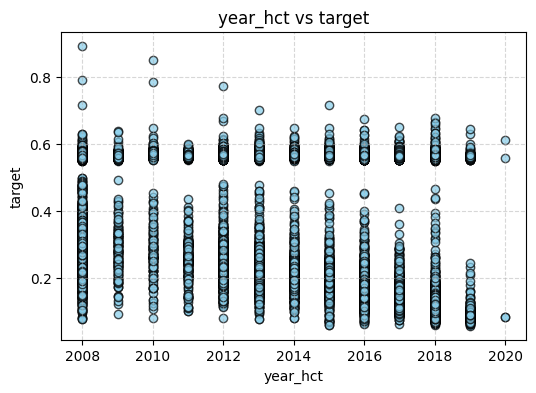

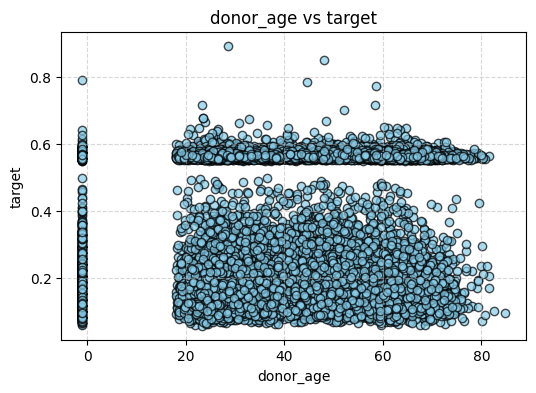

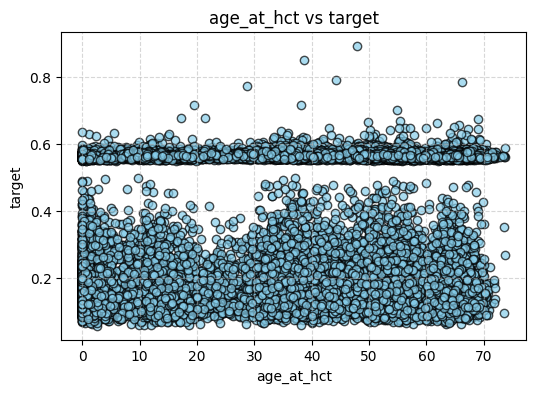

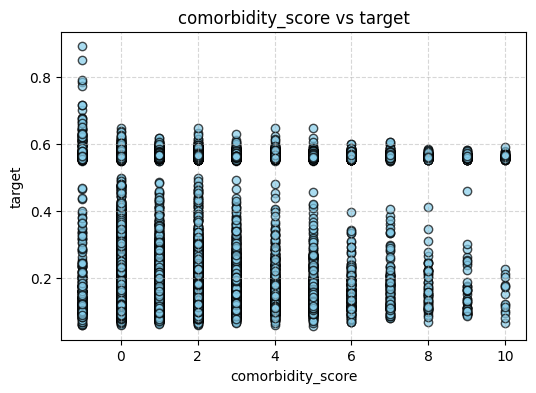

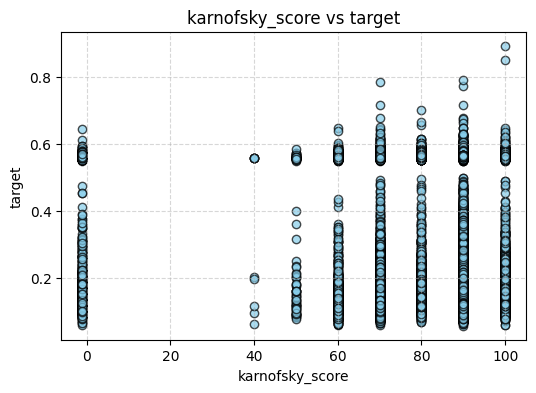

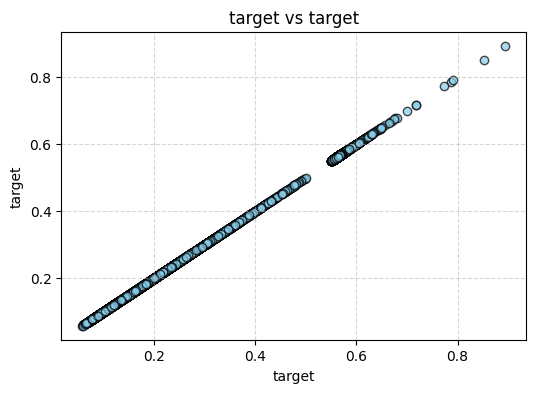

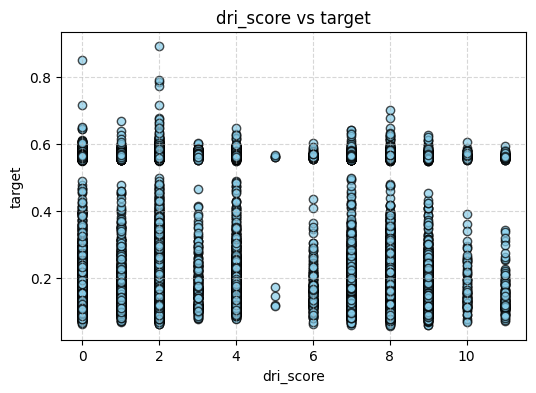

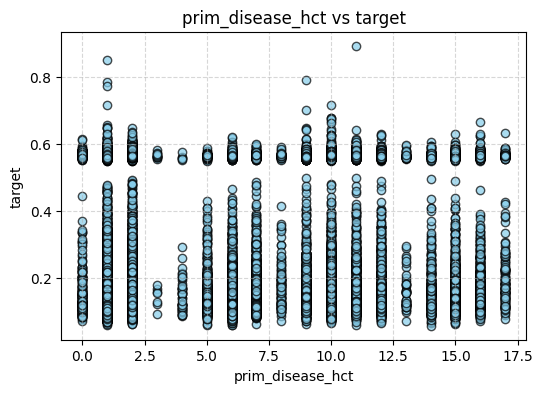

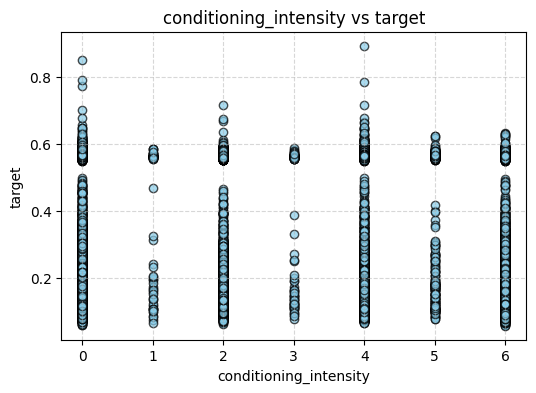

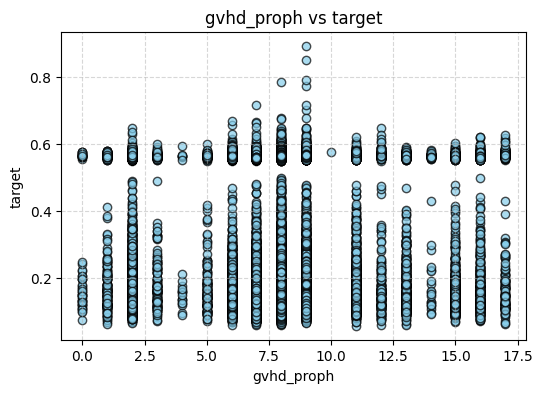

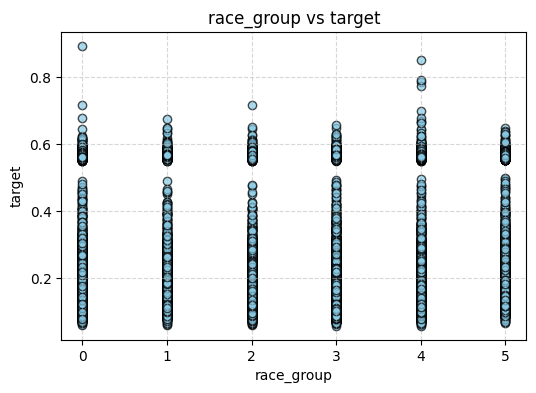

In [14]:
target='target'
for column in df1_subset:
    plt.figure(figsize=(6, 4))
    plt.scatter(df1[column], df1_subset[target], alpha=0.7, color='skyblue', edgecolor='black')
    plt.title(f'{column} vs {target}', fontsize=12)
    plt.xlabel(column, fontsize=10)
    plt.ylabel(target, fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

In [15]:
outliers = df1[(df1['target'] > 0.75) & (df1['year_hct']>=2008) & (df1['year_hct']<=2020)]
print(outliers)

          ID  hla_match_c_high  hla_high_res_8  hla_low_res_6  hla_high_res_6  \
3189    3189               2.0             8.0            6.0             6.0   
4704    4704               1.0            -1.0           -1.0            -1.0   
16822  16822               2.0             8.0            6.0             6.0   
17496  17496               2.0             8.0            6.0             6.0   
23322  23322               2.0             7.0            5.0             5.0   

       hla_high_res_10  hla_match_dqb1_high  hla_nmdp_6  hla_match_c_low  \
3189              10.0                  2.0         6.0              2.0   
4704              -1.0                 -1.0        -1.0             -1.0   
16822             10.0                  2.0         6.0              2.0   
17496             10.0                  2.0         6.0              2.0   
23322              8.0                  1.0         5.0              2.0   

       hla_match_drb1_low  ...  gvhd_proph  rheum_issue 

In [16]:
outliers = df1[(df1['target'] > 0.7) & (df1['donor_age'] >= 0)]
print(outliers)

          ID  hla_match_c_high  hla_high_res_8  hla_low_res_6  hla_high_res_6  \
3189    3189               2.0             8.0            6.0             6.0   
4704    4704               1.0            -1.0           -1.0            -1.0   
10812  10812               2.0             8.0            6.0             6.0   
12573  12573               2.0             8.0            6.0             6.0   
16822  16822               2.0             8.0            6.0             6.0   
17496  17496               2.0             8.0            6.0             6.0   
22663  22663               2.0            -1.0           -1.0            -1.0   

       hla_high_res_10  hla_match_dqb1_high  hla_nmdp_6  hla_match_c_low  \
3189              10.0                  2.0         6.0              2.0   
4704              -1.0                 -1.0        -1.0             -1.0   
10812             -1.0                 -1.0         6.0              2.0   
12573             10.0                  2.0    

In [17]:
# Removing potential outliers from dataset

df1 = df1[~df1['ID'].isin([3189, 4704,10812,16822,17496,22663,12573,23322])]

___

## Final Model 👩🏻‍💻

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer




X= df1.drop(['ID', 'hla_match_c_high', 'hla_high_res_8', 'hla_low_res_6',
       'hla_high_res_6', 'hla_high_res_10', 'hla_match_dqb1_high',
      'hla_nmdp_6', 'hla_match_c_low', 'hla_match_drb1_low',
      'hla_match_dqb1_low', 'hla_match_a_high',
       'hla_match_b_low', 'hla_match_a_low', 'hla_match_b_high', 'hla_low_res_8',
      'hla_match_drb1_high', 'hla_low_res_10', 'efs', 'efs_time',
       'efs_time_scaled', 'target'], axis=1)

y = df1['target']  # Target

In [19]:
from sklearn.ensemble import RandomForestRegressor
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)
# Initialize the Random Forest regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


# Step 5: Make predictions on the test set
y_pred = rf_model.predict(X_test)

In [20]:
y_pred

array([0.48500844, 0.24057272, 0.44321415, ..., 0.46210876, 0.46590695,
       0.45559878])

In [21]:
y_test

19383    0.567524
3317     0.119930
8690     0.564925
12506    0.553192
11392    0.573264
           ...   
4565     0.302655
17726    0.125227
12765    0.560758
24784    0.565284
2412     0.556056
Name: target, Length: 5759, dtype: float64

___

## Similar data processing for Test set

In [22]:
df_test.columns

Index(['ID', 'dri_score', 'psych_disturb', 'cyto_score', 'diabetes',
       'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia',
       'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue',
       'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status',
       'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6',
       'hla_match_c_low', 'rituximab', 'hla_match_drb1_low',
       'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail',
       'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct',
       'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe',
       'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer',
       'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue',
       'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score',
       'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related',
       'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_hi

In [23]:
# collecting all numerical columns into one dataframe for test dataset

numerical_df_test = df_test.select_dtypes(include=['int64', 'float64'])

numerical_df_test[numerical_df_test.select_dtypes(include='number').columns] = numerical_df_test.select_dtypes(include='number').apply(
    lambda col: col.fillna(-1) if col.dtype == 'float64' else col)

numerical_df_test[numerical_df_test.select_dtypes(include='number').columns] = numerical_df_test.select_dtypes(include='number').apply(
    lambda col: col.fillna(0) if col.dtype == 'int64' else col)

#### <div class="alert alert-block alert-info"> 📌  Converting all object type columns into numerical type using label encoding </div>

In [24]:
df_test_object = df_test.select_dtypes(include=['object'])

In [25]:
df_test_object['dri_score'] = label_encoder.fit_transform(df_test_object['dri_score'])
df_test_object['psych_disturb'] = label_encoder.fit_transform(df_test_object['psych_disturb'])
df_test_object['cyto_score'] = label_encoder.fit_transform(df_test_object['cyto_score'])
df_test_object['diabetes'] = label_encoder.fit_transform(df_test_object['diabetes'])
df_test_object['tbi_status'] = label_encoder.fit_transform(df_test_object['tbi_status'])
df_test_object['arrhythmia'] = label_encoder.fit_transform(df_test_object['arrhythmia'])
df_test_object['graft_type'] = label_encoder.fit_transform(df_test_object['graft_type'])
df_test_object['vent_hist'] = label_encoder.fit_transform(df_test_object['vent_hist'])
df_test_object['renal_issue'] = label_encoder.fit_transform(df_test_object['renal_issue'])
df_test_object['pulm_severe'] = label_encoder.fit_transform(df_test_object['pulm_severe'])
df_test_object['gvhd_proph'] = label_encoder.fit_transform(df_test_object['gvhd_proph'])
df_test_object['sex_match'] = label_encoder.fit_transform(df_test_object['sex_match'])
df_test_object['hepatic_mild'] = label_encoder.fit_transform(df_test_object['hepatic_mild'])
df_test_object['tce_div_match'] = label_encoder.fit_transform(df_test_object['tce_div_match'])
df_test_object['donor_related'] = label_encoder.fit_transform(df_test_object['donor_related'])
df_test_object['melphalan_dose'] = label_encoder.fit_transform(df_test_object['melphalan_dose'])
df_test_object['cardiac'] = label_encoder.fit_transform(df_test_object['cardiac'])
df_test_object['pulm_moderate'] = label_encoder.fit_transform(df_test_object['pulm_moderate'])
df_test_object['rheum_issue'] = label_encoder.fit_transform(df_test_object['rheum_issue'])
df_test_object['race_group'] = label_encoder.fit_transform(df_test_object['race_group'])
df_test_object['prim_disease_hct'] = label_encoder.fit_transform(df_test_object['prim_disease_hct'])
df_test_object['cmv_status'] = label_encoder.fit_transform(df_test_object['cmv_status'])
df_test_object['tce_imm_match'] = label_encoder.fit_transform(df_test_object['tce_imm_match'])
df_test_object['rituximab'] = label_encoder.fit_transform(df_test_object['rituximab'])
df_test_object['prod_type'] = label_encoder.fit_transform(df_test_object['prod_type'])
df_test_object['cyto_score_detail'] = label_encoder.fit_transform(df_test_object['cyto_score_detail'])
df_test_object['conditioning_intensity'] = label_encoder.fit_transform(df_test_object['conditioning_intensity'])
df_test_object['ethnicity'] = label_encoder.fit_transform(df_test_object['ethnicity'])
df_test_object['obesity'] = label_encoder.fit_transform(df_test_object['obesity'])
df_test_object['mrd_hct'] = label_encoder.fit_transform(df_test_object['mrd_hct'])
df_test_object['in_vivo_tcd'] = label_encoder.fit_transform(df_test_object['in_vivo_tcd'])
df_test_object['tce_match'] = label_encoder.fit_transform(df_test_object['tce_match'])
df_test_object['hepatic_severe'] = label_encoder.fit_transform(df_test_object['hepatic_severe'])
df_test_object['prior_tumor'] = label_encoder.fit_transform(df_test_object['prior_tumor'])
df_test_object['peptic_ulcer'] = label_encoder.fit_transform(df_test_object['peptic_ulcer'])


In [26]:
df_test_object.dtypes

dri_score                 int64
psych_disturb             int64
cyto_score                int64
diabetes                  int64
tbi_status                int64
arrhythmia                int64
graft_type                int64
vent_hist                 int64
renal_issue               int64
pulm_severe               int64
prim_disease_hct          int64
cmv_status                int64
tce_imm_match             int64
rituximab                 int64
prod_type                 int64
cyto_score_detail         int64
conditioning_intensity    int64
ethnicity                 int64
obesity                   int64
mrd_hct                   int64
in_vivo_tcd               int64
tce_match                 int64
hepatic_severe            int64
prior_tumor               int64
peptic_ulcer              int64
gvhd_proph                int64
rheum_issue               int64
sex_match                 int64
race_group                int64
hepatic_mild              int64
tce_div_match             int64
donor_re

In [27]:
# Merging numerical and object type columns into one dataframe

for col in df_test_object.columns:
    numerical_df_test[col] = df_test_object[col]

In [28]:



numerical_df_test_noID= numerical_df_test.drop(['ID', 'hla_match_c_high', 'hla_high_res_8', 'hla_low_res_6',
       'hla_high_res_6', 'hla_high_res_10', 'hla_match_dqb1_high',
       'hla_nmdp_6', 'hla_match_c_low', 'hla_match_drb1_low',
       'hla_match_dqb1_low', 'hla_match_a_high',
       'hla_match_b_low', 'hla_match_a_low', 'hla_match_b_high', 'hla_low_res_8',
       'hla_match_drb1_high', 'hla_low_res_10'], axis=1)

## Predicting Test set

In [29]:
test_pred = rf_model.predict(numerical_df_test_noID)

In [30]:
test_pred

array([0.33026053, 0.42848786, 0.23929128])

In [31]:
numerical_df_test['prediction']=test_pred
submission = numerical_df_test[['ID', 'prediction']]
submission.to_csv('submission.csv', index=False)

___

## Feature Importance in Random Forest Model

year_hct: 0.07334766864356224
donor_age: 0.10211379929317126
age_at_hct: 0.10973312641979956
comorbidity_score: 0.0379050557122853
karnofsky_score: 0.03010178450702994
dri_score: 0.036027908685176864
psych_disturb: 0.011103177126385325
cyto_score: 0.02745910741504558
diabetes: 0.011228996543818572
tbi_status: 0.021379560232170833
arrhythmia: 0.007742024725079384
graft_type: 0.010455446086051692
vent_hist: 0.005202478499302914
renal_issue: 0.0047947692300373814
pulm_severe: 0.009404428548571403
prim_disease_hct: 0.039219931804629814
cmv_status: 0.02734290464514491
tce_imm_match: 0.017899517448233083
rituximab: 0.006658915250636136
prod_type: 0.008243886184935543
cyto_score_detail: 0.019555490298398842
conditioning_intensity: 0.1062888831041902
ethnicity: 0.01282725494405357
obesity: 0.008822552602318177
mrd_hct: 0.014938062876069762
in_vivo_tcd: 0.011867392217899444
tce_match: 0.01668800117098177
hepatic_severe: 0.008152862364213875
prior_tumor: 0.00970425780590149
peptic_ulcer: 0.00610

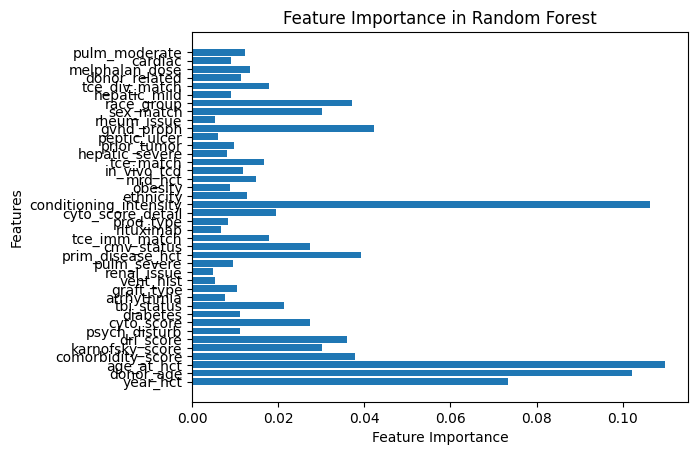

In [32]:
# Get feature importance
feature_importance = rf_model.feature_importances_
features = X_train.columns  

# Display the importance
for feature, importance in zip(features, feature_importance):
    print(f"{feature}: {importance}")

# Visualize feature importance
import matplotlib.pyplot as plt

plt.barh(features, feature_importance)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest")
plt.show()

___

## Distribution of values in important features 

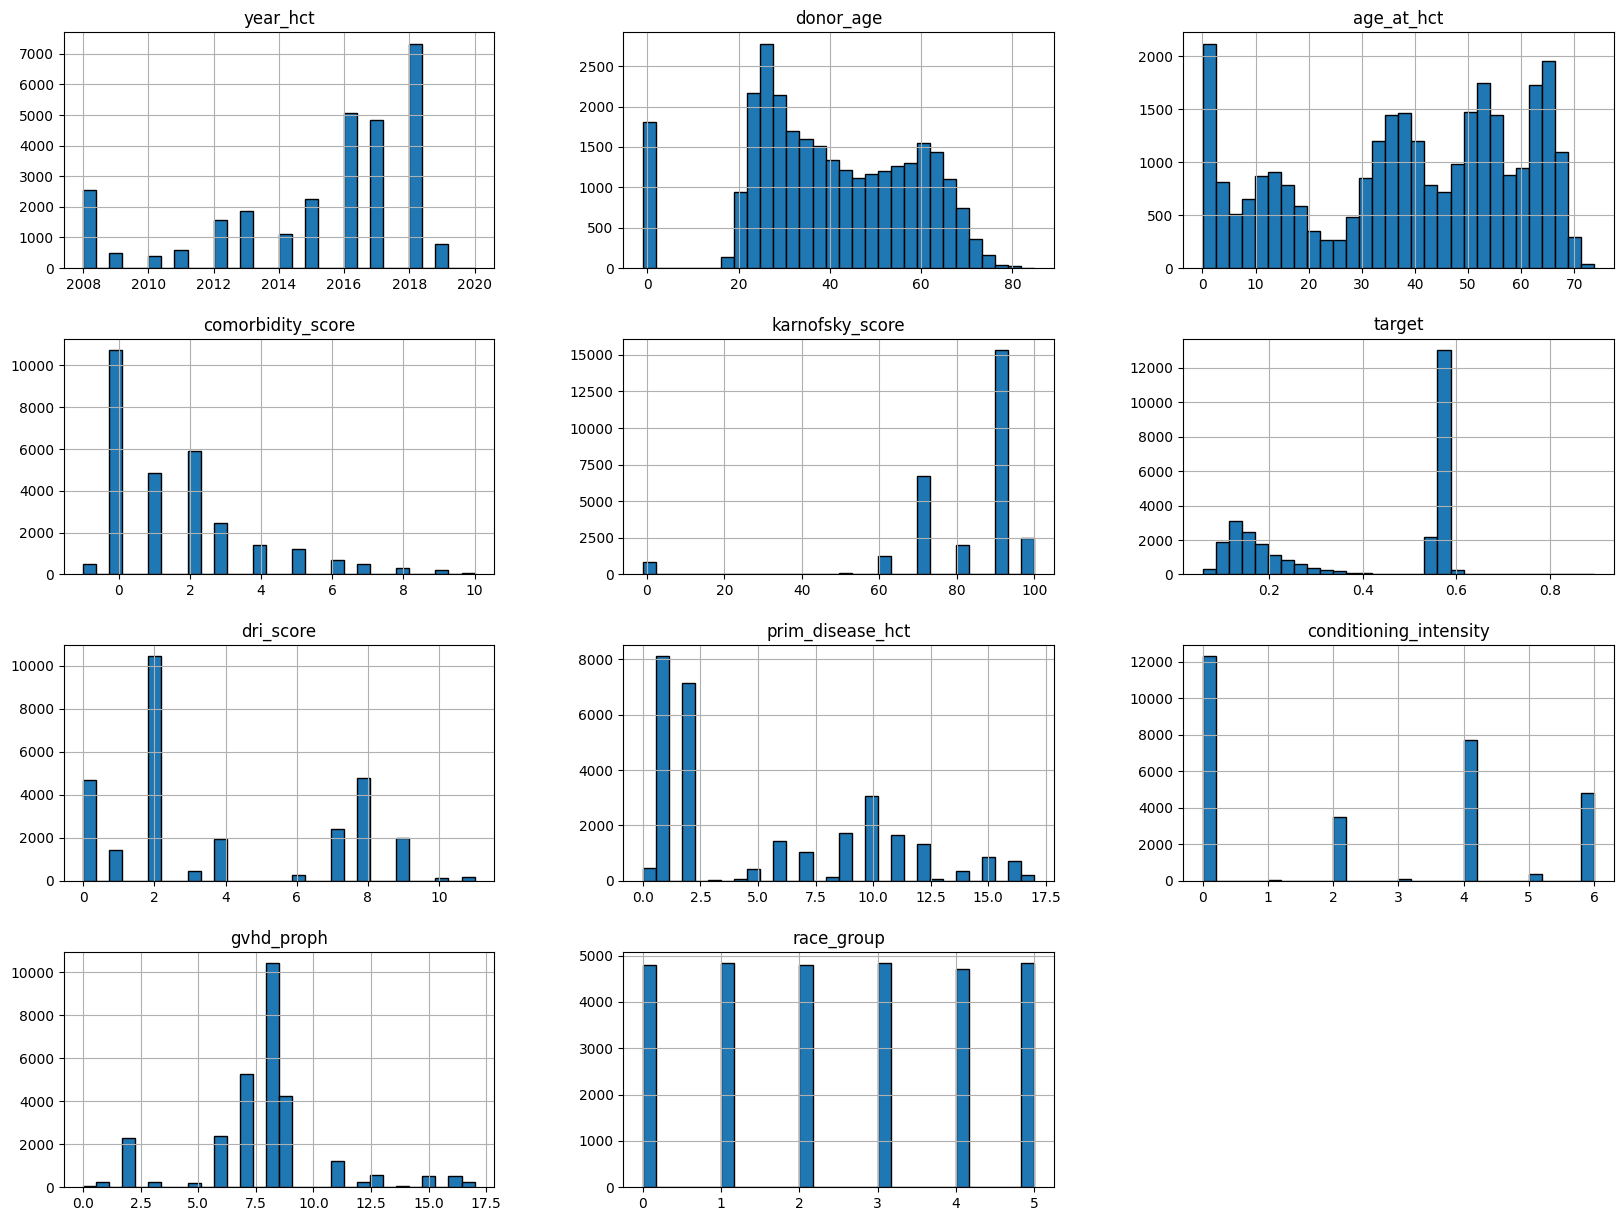

In [33]:
df1_subset.hist(figsize=(20, 15), bins=30, edgecolor='black')
plt.show()